In [ ]:
!pip install -U albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=256, width=256),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=350),
        A.CenterCrop(height=256, width=256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
# !unzip dataset.zip

In [ ]:
train_data_path = 'dataset/train' 
test_data_path = 'dataset/test'

In [ ]:
train_image_paths = [] #to store image paths in list
classes = []

In [ ]:
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))

In [ ]:
classes

['not_logging', 'logging']

In [ ]:
# train_image_paths

In [ ]:
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

In [ ]:
# train_image_paths

In [ ]:
print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

train_image_path example:  dataset/train/logging/water logging in school_32.jpeg
class example:  not_logging


In [ ]:
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

In [ ]:
len(train_image_paths)

71

In [ ]:
len(valid_image_paths)

18

In [ ]:
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


Train size: 71
Valid size: 18
Test size: 10


In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [ ]:
idx_to_class

{0: 'not_logging', 1: 'logging'}

In [ ]:
class_to_idx

{'not_logging': 0, 'logging': 1}

In [ ]:
class LandmarkDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label
        

In [ ]:
train_dataset = LandmarkDataset(train_image_paths,train_transforms)
valid_dataset = LandmarkDataset(valid_image_paths,test_transforms) #test transforms are applied
test_dataset = LandmarkDataset(test_image_paths,test_transforms)

In [ ]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 256, 256])
The label for 50th image in train dataset:  0


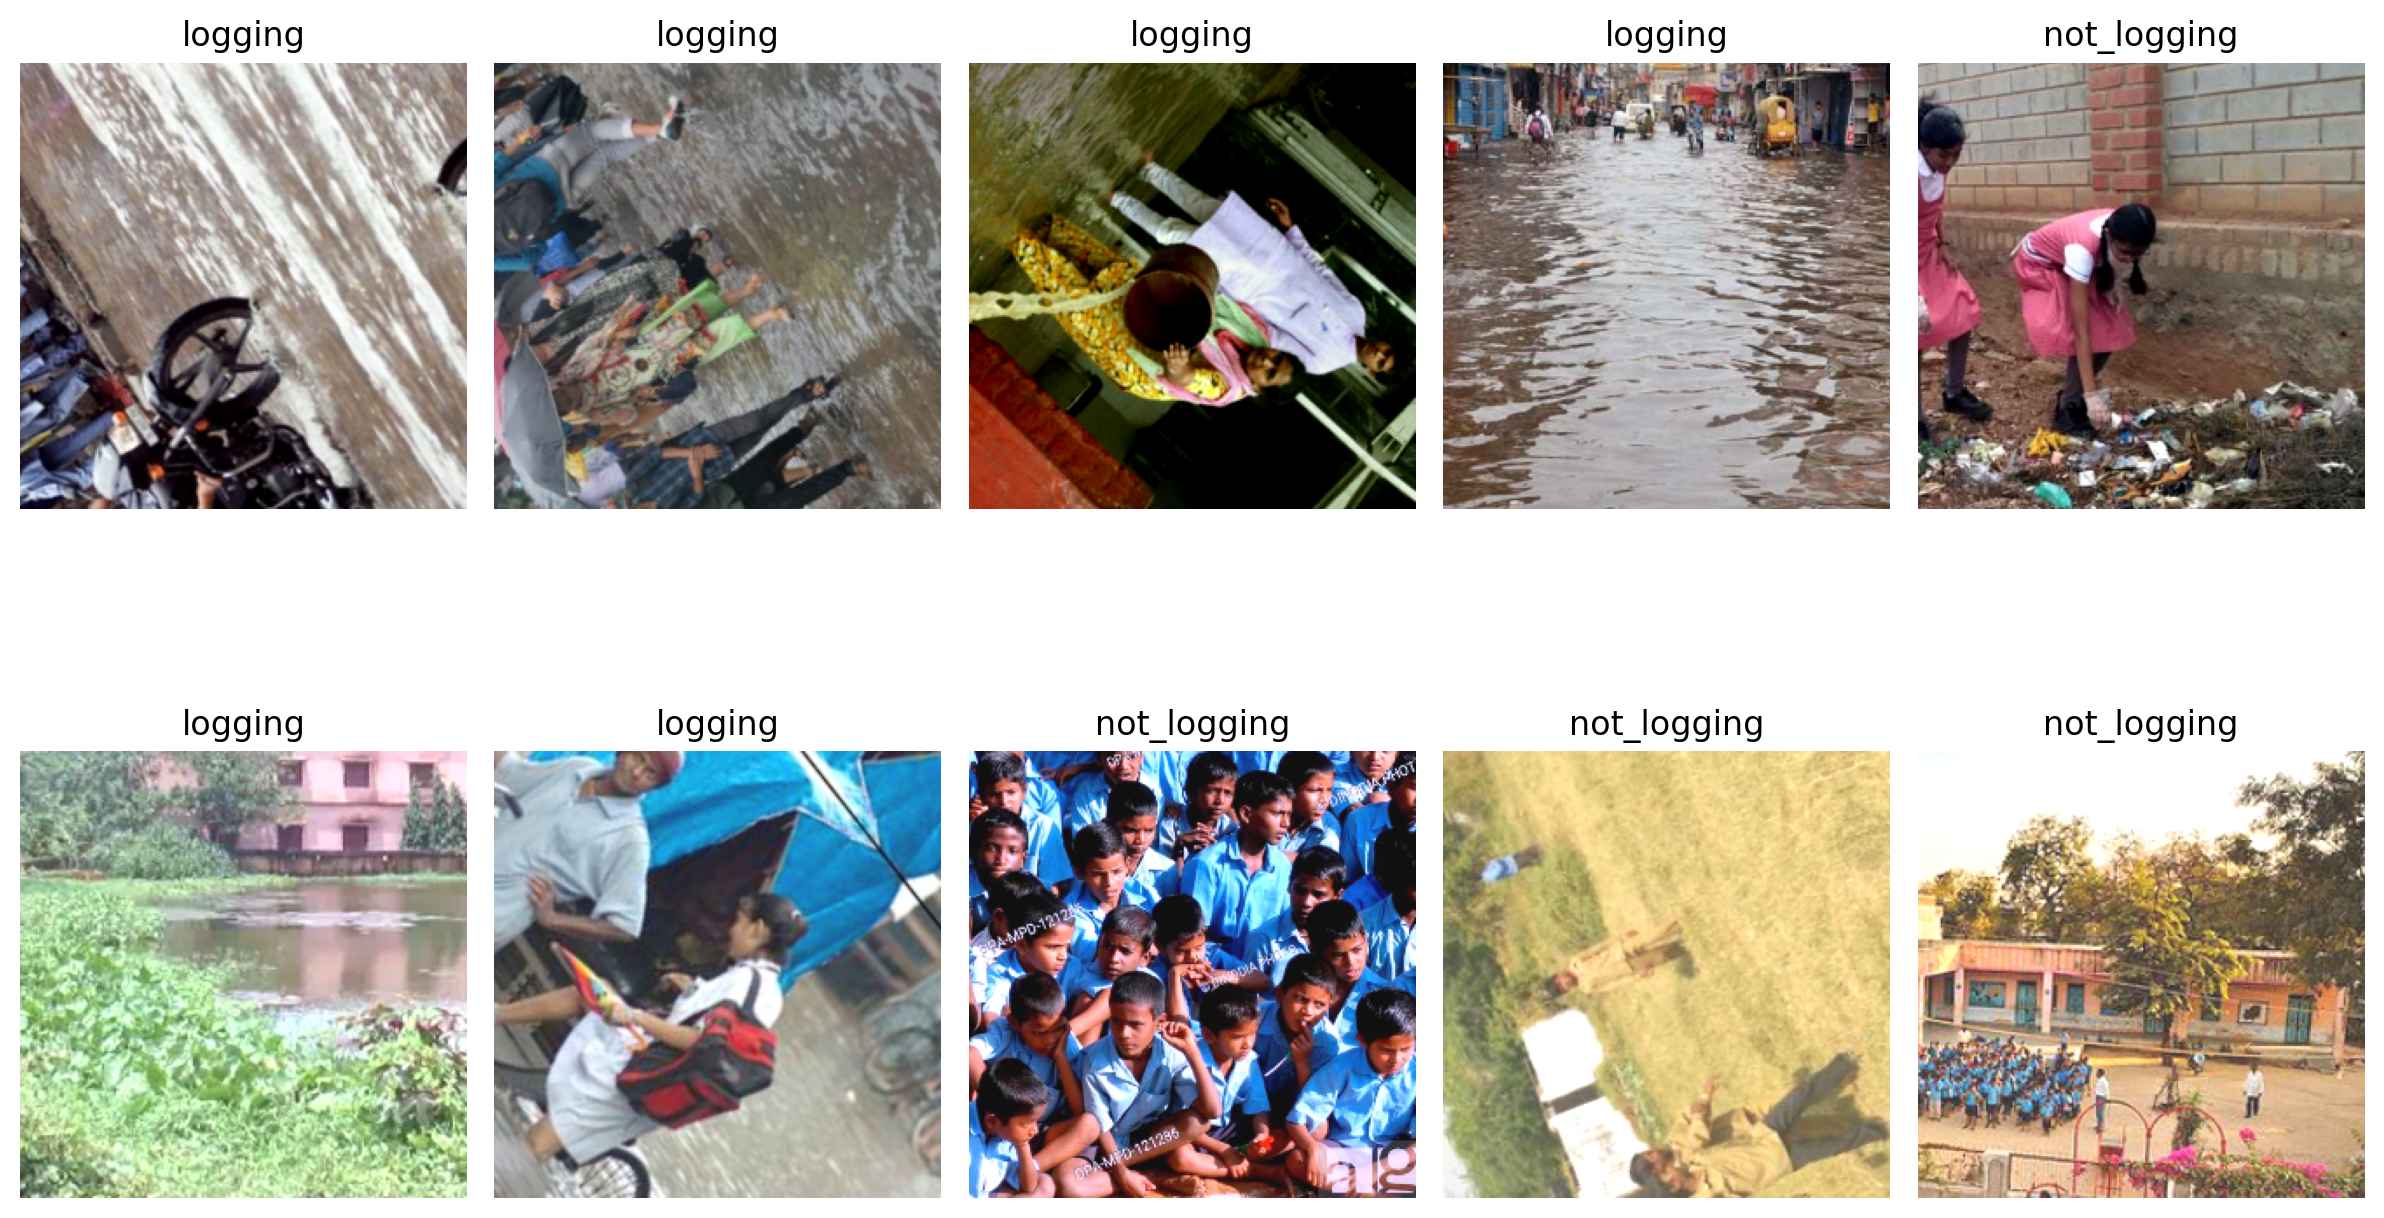

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)


In [ ]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=32, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def traineval(model, num_epochs, criterion, optimizer):
    
    losses = {'train' : [], 'valid': []}
    accs = {'train' : [], 'valid': []}
    # keeping-track-of-losses    
    train_samples,train_correct,valid_samples, valid_correct = 0,0,0,0
    

    for epoch in range(1, num_epochs + 1):
        # keep-track-of-training-and-validation-loss
        train_loss = 0.0
        valid_loss = 0.0
    
        # training-the-model
        model.train()
        for data, target in train_loader:
            # move-tensors-to-GPU 
            data = data.to(device)
            target = target.to(device)
        
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            _, predicted = torch.max(output, 1)
            train_samples += target.size(0)
            train_correct += (predicted == target).sum().item()
        
            train_acc = 100.0 * train_correct / train_samples
            
            # calculate-the-batch-loss
            loss = criterion(output, target)
            
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            
            # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
            
            # update-training-loss
            train_loss += loss.item() * data.size(0)
        
        
        model.eval()
        for data, target in valid_loader:
        
            data = data.to(device)
            target = target.to(device)
        
            output = model(data)
            _, predicted = torch.max(output, 1)
            valid_samples += target.size(0)
            valid_correct += (predicted == target).sum().item()
        
            val_acc = 100.0 * valid_correct / valid_samples
        
            loss = criterion(output, target)
        
            # update-average-validation-loss 
            valid_loss += loss.item() * data.size(0)
    
        # calculate-average-losses and Accuracies
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
    
    
        losses['train'].append(train_loss)
        losses['valid'].append(valid_loss)
        accs['train'].append(train_acc)
        accs['valid'].append(val_acc)
        
        print('Epoch: {} Training Loss: {:.6f} Validation Loss: {:.6f} Training accuracy: {:.6f} Valid accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss, train_acc, val_acc))
        
    return losses, accs
#Plot Loss & Accuracy Graph


In [ ]:
model =  models.vgg16(pretrained=True)

#Freeze conv layers
for param in model.parameters():
    param.requires_grad = False

#Load Weights


print("Original VGG16 Model:\n", model)

Original VGG16 Model:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2

In [ ]:
model.classifier = nn.Sequential(
                      nn.Linear(25088,256),
                      nn.ReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(256,2)
                   )

print("New VGG16 Model:\n", model)

New VGG16 Model:
 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pad

In [ ]:
model = model.to(device)

num_epochs = 500

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
losses, accs = traineval(model,num_epochs,criterion, optimizer)

Epoch: 1 Training Loss: 1.498041 Validation Loss: 1.980313 Training accuracy: 50.704225 Valid accuracy: 66.666667
Epoch: 2 Training Loss: 3.538059 Validation Loss: 3.391487 Training accuracy: 51.408451 Valid accuracy: 55.555556
Epoch: 3 Training Loss: 3.674444 Validation Loss: 2.249366 Training accuracy: 52.112676 Valid accuracy: 55.555556
Epoch: 4 Training Loss: 2.116242 Validation Loss: 0.317840 Training accuracy: 54.577465 Valid accuracy: 63.888889
Epoch: 5 Training Loss: 0.963114 Validation Loss: 0.819572 Training accuracy: 58.028169 Valid accuracy: 67.777778
Epoch: 6 Training Loss: 1.694010 Validation Loss: 0.039654 Training accuracy: 58.920188 Valid accuracy: 73.148148
Epoch: 7 Training Loss: 0.853339 Validation Loss: 0.240874 Training accuracy: 60.764588 Valid accuracy: 75.396825
Epoch: 8 Training Loss: 0.845047 Validation Loss: 0.039169 Training accuracy: 61.267606 Valid accuracy: 78.472222
Epoch: 9 Training Loss: 0.624468 Validation Loss: 0.104683 Training accuracy: 62.284820 

KeyboardInterrupt: ignored